In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
import math
import random
from sklearn.manifold import TSNE
from scipy.integrate import simps
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation
import scipy.signal
from scipy.stats import exponnorm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lmfit.models import GaussianModel,ExponentialGaussianModel,SkewedGaussianModel,VoigtModel,LorentzianModel,LognormalModel,ExponentialModel,LinearModel
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy
import pybaselines
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=2.5)
sns.set_style("white")

# Figure 1A 
HPLC column dynamics with NO diffusion, only MM kinetics for column binding/unbinding 
1. 100 events bind to column at location x
2. Unbind at each time step with probability p 
3. Move with no diffusion towards end of the column 
4. Generate arrival time disbituion 

In [4]:
count_matrix=[]

for x in range(10000):
    count=1
    solvent_front=np.zeros(1000)
    column=np.zeros(1000)
    #100 events on column 
    column[100]=100
    #while there is solvent still on the column
    while sum(column)+sum(solvent_front)>0:
        #increase time step
        count+=1
        for i in range(len(column)):
            #10% chance of unbinding
            if column[i]>0 and solvent_front[i]==0:
                quant=0
                for y in range(int(column[i])):
                    bound=np.random.uniform(0,1)
                    if bound<0.05:
                        quant+=1
                column[i]-=quant
                solvent_front[i]+=quant
        #add new empty solvent to back of column, pop front off 
        end, solvent_front = solvent_front[-1], solvent_front[:-1]
        solvent_front=np.insert(solvent_front,0,0)
        #adds a data point for each analyte 
        for n in range(int(end)):
            count_matrix.append(count)
    



In [7]:
with open("nodiffusion_sim.txt", "w") as output:
    output.write(str(count_matrix))

In [2]:
sim = open("nodiffusion_sim.txt", "r") 
  
# reading the file 
data = sim.read() 
  
count_matrix2 = data.replace('[','').replace(']','').split(",") 
count_matrix3 = [round(float(i)+50) for i in count_matrix2]



Text(0.5, 1.0, 'Dectector Arrival Time with no Difussion')

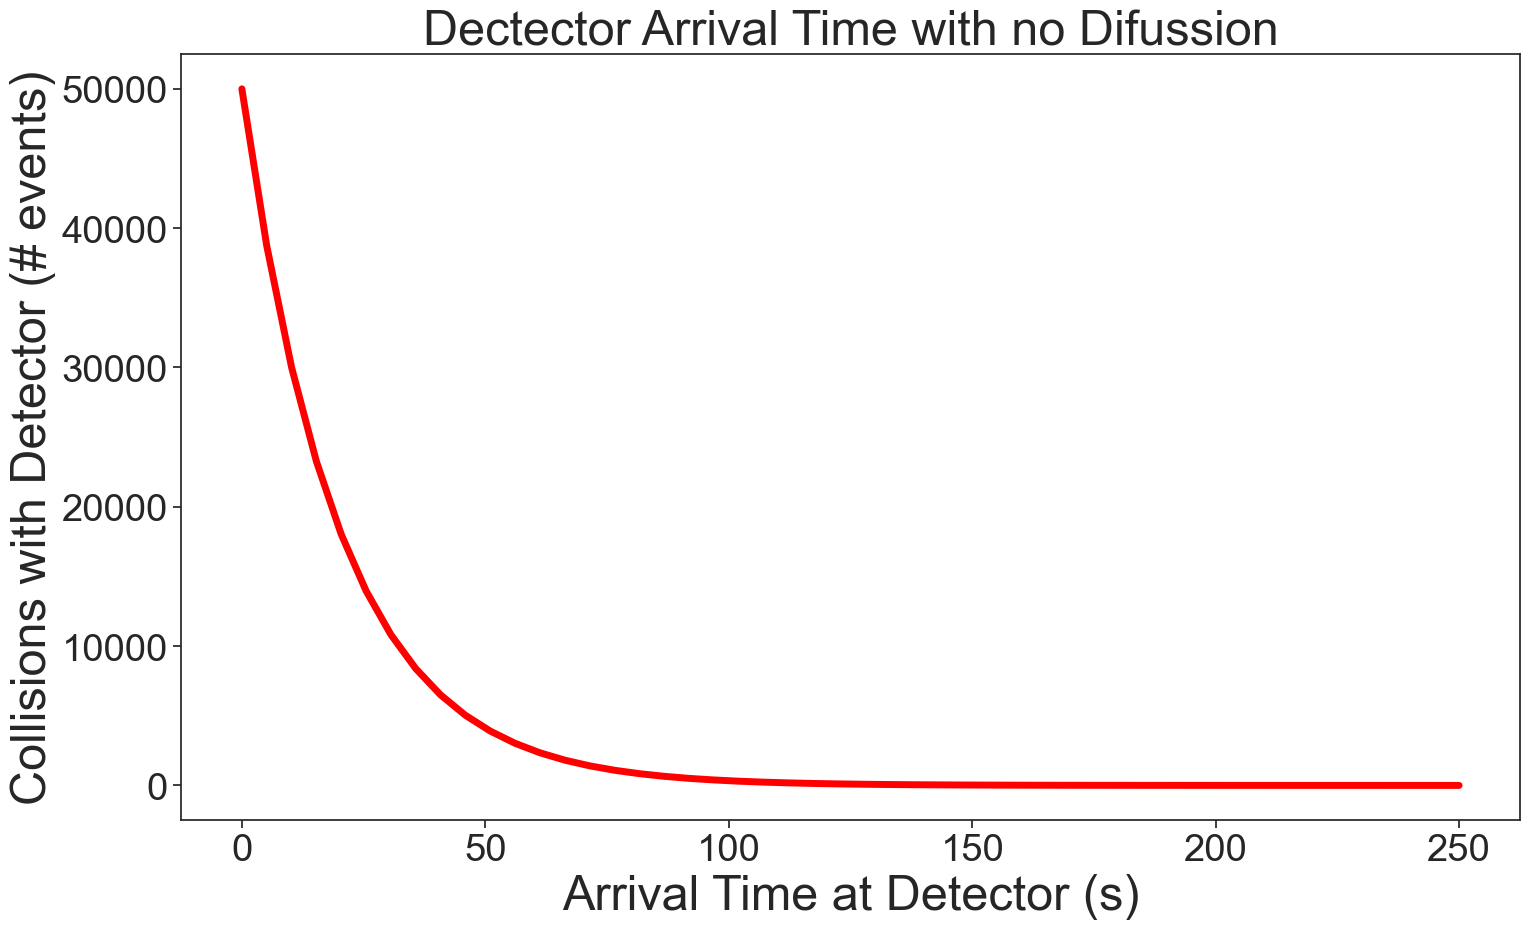

In [3]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(16, 10))
x=np.linspace(0,250)
y=50000*(math.e**(-0.05*x))
ax.plot(x,y,color="red",linewidth=5)
ax.set_xlabel("Arrival Time at Detector (s)",size=35)
ax.set_ylabel("Collisions with Detector (# events)",size=35)
ax.set_title("Dectector Arrival Time with no Difussion",size=35)

(0.0, 50000.0)

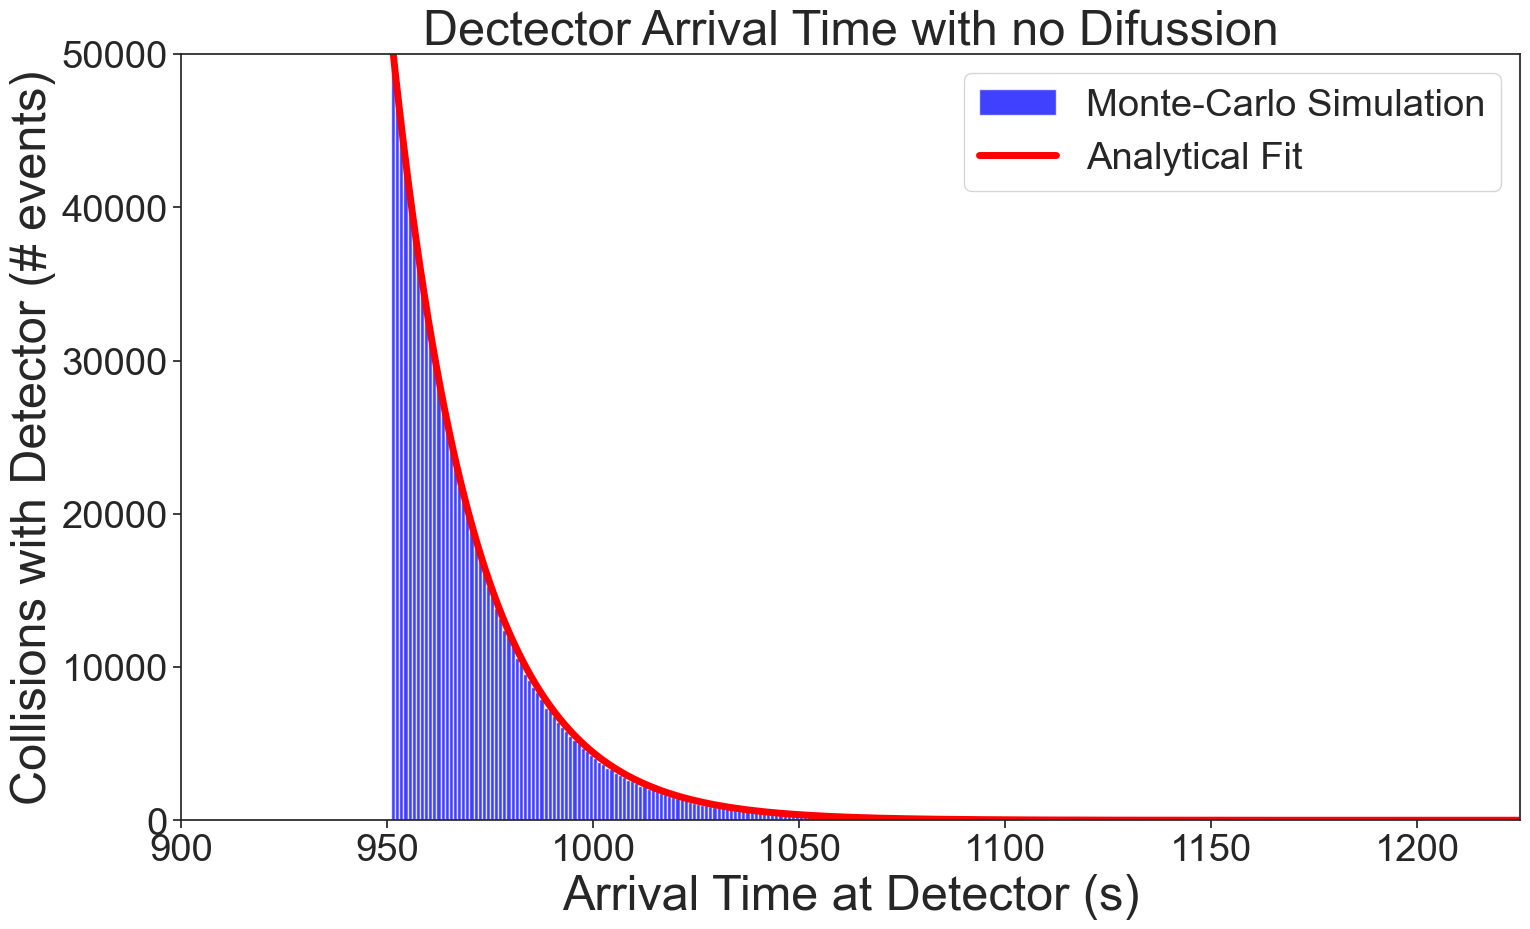

In [17]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(16, 10))


n,bins,patches= ax.hist(count_matrix3,bins=int(max(count_matrix3)-min(count_matrix3)),color="blue",alpha=0.75,label="Monte-Carlo Simulation")
n=np.insert(n,0,0)

exp=ExponentialModel()
model=exp
pars = model.guess(n, x=bins)

pars["amplitude"].set(value=5e8)
pars["decay"].set(value=100)



# plot results


#to get best fit 

out = model.eval(amplitude=625000,decay=20, x=bins-901)

#print(out.params)

ax.plot(bins, out, '-', label='Analytical Fit',color="red",linewidth=5)


ax.set_xlabel("Arrival Time at Detector (s)",size=35)
ax.set_ylabel("Collisions with Detector (# events)",size=35)
ax.set_title("Dectector Arrival Time with no Difussion",size=35)
ax.legend()
ax.set_xlim(900,1225)
ax.set_ylim(0,50000)


In [ ]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(16, 10))
x=np.linspace(0,250)
y=50000*(math.e**(-0.05*x))
ax.plot(x,y,color="red",linewidth=5)
ax.set_xlabel("Arrival Time at Detector (s)",size=35)
ax.set_ylabel("Collisions with Detector (# events)",size=35)
ax.set_title("Dectector Arrival Time with no Difussion",size=35)

# Figure 2B 
1. Add a step where there is free binding/ubinding from column 
2. When solvent front arrives, langemuir kinetics 

In [6]:
count_matrix=[]

for x in range(10000):
    count=1
    solvent_front=np.zeros(1000)
    column=np.zeros(1000)
    #100 events on column 
    solvent_front[0]=100
    for t in range(125):
        for i in range(len(column)):
            quant=0
            for y in range(int(column[i])):
                bound=np.random.uniform(0,1)
                if bound<0.5:
                    quant+=1
            column[i]-=quant
            solvent_front[i]+=quant
            quant=0
            for z in range(int(solvent_front[i])):
                bound=np.random.uniform(0,1)
                if bound<0.5:
                    quant+=1
            column[i]+=quant
            solvent_front[i]-=quant
            end, solvent_front = solvent_front[-1], solvent_front[:-1]
            solvent_front=np.insert(solvent_front,0,0)
    #while there is solvent still on the column
    while sum(column)+sum(solvent_front)>0:
        #increase time step
        count+=1
        for i in range(len(column)):
            #10% chance of unbinding
            if column[i]>0:
                quant=0
                for y in range(int(column[i])):
                    bound=np.random.uniform(0,1)
                    if bound<0.05:
                        quant+=1
                column[i]-=quant
                solvent_front[i]+=quant
        #add new empty solvent to back of column, pop front off 
        end, solvent_front = solvent_front[-1], solvent_front[:-1]
        solvent_front=np.insert(solvent_front,0,0)
        #adds a data point for each analyte 
        for n in range(int(end)):
            count_matrix.append(count)

In [7]:
with open("rebind_sim.txt", "w") as output:
    output.write(str(count_matrix))

In [5]:
sim = open("rebind_sim.txt", "r") 
  
# reading the file 
data = sim.read() 
  
dif_matrix2 = data.replace('[','').replace(']','').split(",") 
dif_matrix3 = [round(float(i)) for i in dif_matrix2]

Text(0.5, 1.0, 'Dectector Arrival Time with Rebinding')

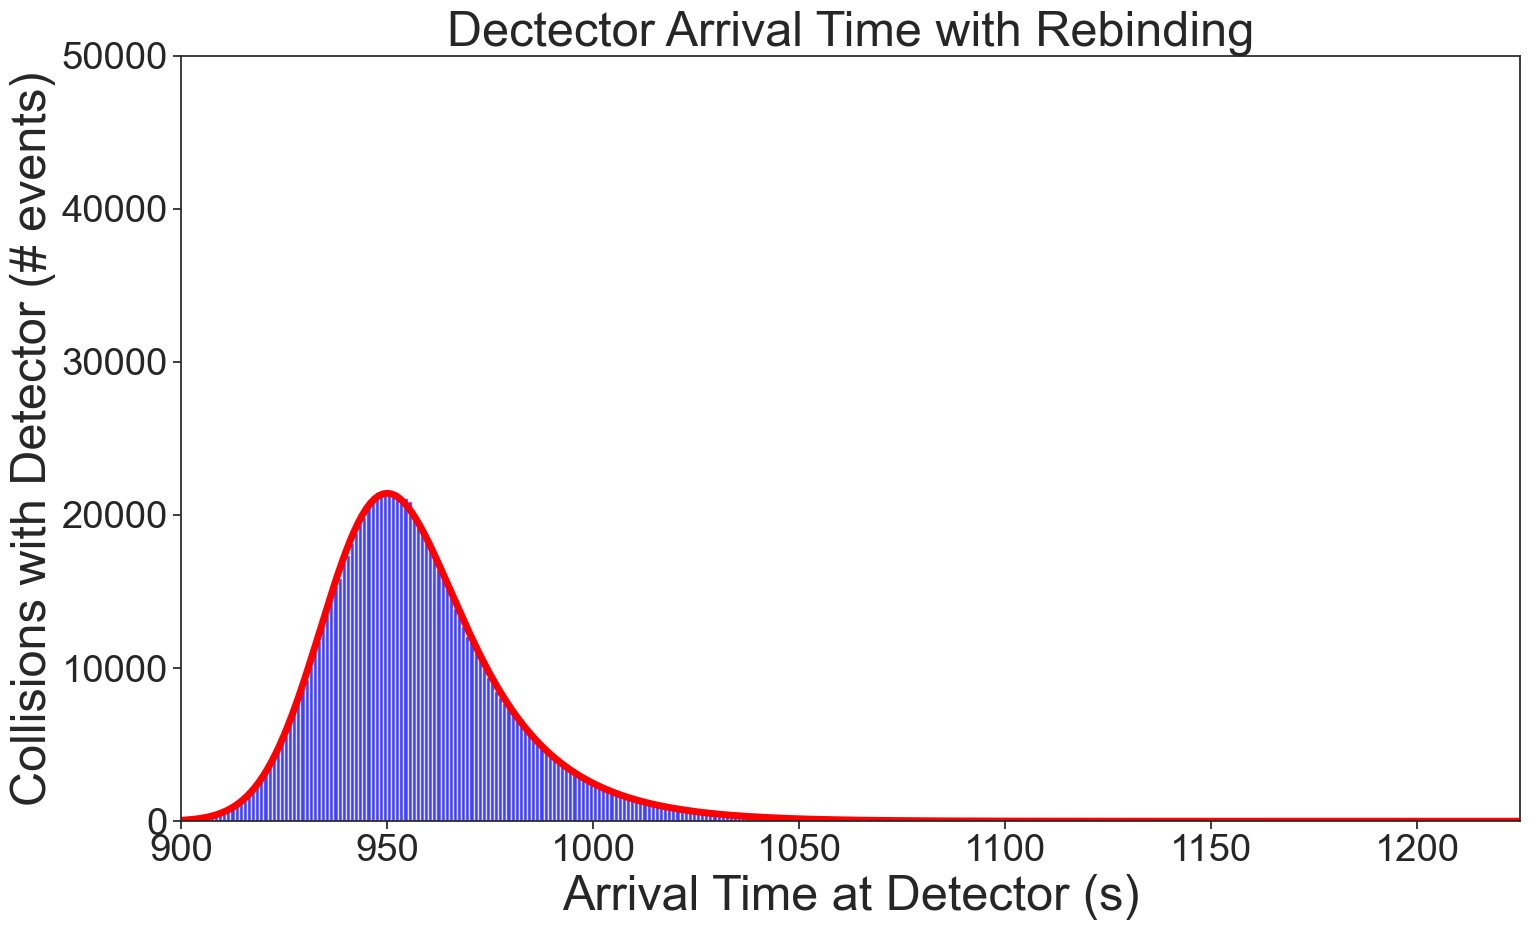

In [7]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(16, 10))


n,bins,patches= ax.hist(dif_matrix3,bins=int(max(dif_matrix3)-min(dif_matrix3)),color="blue",alpha=0.75,label="Monte-Carlo Simulation")
gaus=ExponentialGaussianModel()
lnormal=LognormalModel()
model=gaus



#out = lnormal.eval(amplitude=10,center=450,sigma=1, x=bins)
out2 = model.eval(amplitude=1000000,center=939,sigma=13,gamma=0.055, x=bins)
#print(out2.params)


#ax.plot(bins, out.best_fit, '-', label='best fit',color="orange",linewidth=4)
ax.plot(bins, out2, '-', label='Analytical fit',color="red",linewidth=5)
#ax.plot(bins, out, '-', label='L normal',color="orange",linewidth=5)
ax.set_ylim(0,50000)
ax.set_xlim(900,1225)

ax.set_xlabel("Arrival Time at Detector (s)",size=35)
ax.set_ylabel("Collisions with Detector (# events)",size=35)
ax.set_title("Dectector Arrival Time with Rebinding",size=35)